# Project: Wrangling and Analyzing Data

## Projects steps overview
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gathering data</a></li>
<li><a href="#access">Assessing data</a></li>
<li><a href="#clean">Cleaning data</a></li>
<li><a href="#store">Storing data</a></li>
<li><a href="#avd">Analyzing, and visualizing data</a></li>
<li><a href="#report">Reporting</a></li>
</ul>

<a id='intro'></a>
## Introduction
<!-- 
This is a part of the projects I did in the Udacity Data Analyst Nanodegree Programme.
 -->
The dataset that I'll be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "[they're good dogs Brent.](http://knowyourmeme.com/memes/theyre-good-dogs-brent)" WeRateDogs has over 4 million followers and has received international media coverage.

In this project, I'll wrangle `WeRateDogs` Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. I will then make `additional gathering`, then `assessing` and `cleaning` which is required for **"Wow!"**-worthy analyses and visualizations.

In [1]:
# import libraries and packages
import pandas as pd
import numpy as np
import json as js
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_theme(style='white', palette='muted')
import requests
import tweepy as tw
from tweepy import OAuthHandler
import configparser
import timeit
import regex as re

import warnings
warnings.filterwarnings(action='ignore')

<a id='gather'></a>
## Data Gathering
I will work on three (3) different datasets here:
 - **Enhanced Twitter Archive**<br>
Here, I downloaded this dataset directly, the `twitter-archive-enhanced.csv` which is the archive that contains basic tweet data.

In [2]:
df_arch = pd.read_csv('twitter-archive-enhanced.csv')

 - **Image Predictions File**<br>
I used the `requests` library to download the tweet image prediction `image_predictions.tsv` file.

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response.status_code

200

In [4]:
with open('image-predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [5]:
df_pred = pd.read_csv('image-predictions.tsv', sep='\t')

tweet_id is the last part of the tweet URL after "status/"<br>
p1 is the algorithm's #1 prediction for the image in the tweet<br>
p1_conf is how confident the algorithm is in its #1 prediction<br>
p1_dog is whether or not the #1 prediction is a breed of dog<br>
p2 is the algorithm's second most likely prediction<br>
p2_conf is how confident the algorithm is in its #2 prediction<br>
p2_dog is whether or not the #2 prediction is a breed of dog<br>

 - **Additional Data via the Twitter API**<br>
Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least. Here, I'm going to query Twitter's API to gather this valuable data.

In [6]:
# This config file contains API Keys, Secrets, and Tokens
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [7]:
api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

In [8]:
auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [17]:
count = 0
fails_dict = {}
start = timeit.timeit()
with open('tweet.json.txt', 'w') as outfile:
    for i in df_arch.tweet_id.values:
        count += 1
        print(str(count) + ': ' + str(i))
        try:
            tweet = api.get_status(i, tweet_mode='extended')
            print('success')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tw.TweepyException as e:
            print('fail')
            fails_dict[i] = e
            pass
end = timeit.timeit()
print('Time taken to run: {}'.format(end-start))
print(fails_dict)

1: 892420643555336193
success
2: 892177421306343426
success
3: 891815181378084864
success
4: 891689557279858688
success
5: 891327558926688256
success
6: 891087950875897856
success
7: 890971913173991426
success
8: 890729181411237888
success
9: 890609185150312448
success
10: 890240255349198849
success
11: 890006608113172480
success
12: 889880896479866881
success
13: 889665388333682689
success
14: 889638837579907072
success
15: 889531135344209921
success
16: 889278841981685760
success
17: 888917238123831296
success
18: 888804989199671297
success
19: 888554962724278272
success
20: 888202515573088257
fail
21: 888078434458587136
success
22: 887705289381826560
success
23: 887517139158093824
success
24: 887473957103951883
success
25: 887343217045368832
success
26: 887101392804085760
success
27: 886983233522544640
success
28: 886736880519319552
success
29: 886680336477933568
success
30: 886366144734445568
success
31: 886267009285017600
success
32: 886258384151887873
success
33: 8860541600590725

In [9]:
file = 'tweet.json.txt'
df_tw = []
with open(file, 'r') as f:
    for line in f:
        tweet = (json.loads(line))
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        create_date = tweet['created_at']
        text = tweet['full_text']
        df_tw.append({
            'tweet_id': tweet_id,
            'retweet_count': retweet_count,
            'favorite_count': favorite_count,
            'created_at': create_date,
            'text': text
        })
df_tw = pd.DataFrame(df_tw, columns=['tweet_id', 'retweet_count', 'favorite_count', 'text', 'created_at'])

In [10]:
# file = 'tweet-json.txt'
# df_tw = []
# with open(file, 'r') as f:
#     for line in f:
#         tweet = (json.loads(line))
#         tweet_id = tweet['id']
#         retweet_count = tweet['retweet_count']
#         favorite_count = tweet['favorite_count']
#         create_date = tweet['created_at']
#         text = tweet['full_text']
#         df_tw.append({
#             'tweet_id': tweet_id,
#             'retweet_count': retweet_count,
#             'favorite_count': favorite_count,
#             'created_at': create_date,
#             'text': text
#         })
# df_tw = pd.DataFrame(df_tw, columns=['tweet_id', 'retweet_count', 'favorite_count', 'text', 'created_at'])
# df_tw

<a id='access'></a>
## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



**Visual Assessment**
I made some visual assessments in jupyter lab using the csv reader to quickly look through the data. I also made use of Microsoft Excel.

In [11]:
df_arch

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [12]:
df_pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [13]:
df_tw

,tweet_id,retweet_count,favorite_count,text,created_at
0,892420643555336193,6877,32891,This is Phineas. He's a mystical boy. Only eve...,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,5178,28427,This is Tilly. She's just checking pup on you....,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,3422,21368,This is Archie. He is a rare Norwegian Pouncin...,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,7086,35859,This is Darla. She commenced a snooze mid meal...,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,7596,34307,This is Franklin. He would like you to stop ca...,Sat Jul 29 16:00:24 +0000 2017
...,...,...,...,...,...
2319,666049248165822465,35,85,Here we have a 1949 1st generation vulpix. Enj...,Mon Nov 16 00:24:50 +0000 2015
2320,666044226329800704,113,242,This is a purebred Piers Morgan. Loves to Netf...,Mon Nov 16 00:04:52 +0000 2015
2321,666033412701032449,35,98,Here is a very happy pup. Big fan of well-main...,Sun Nov 15 23:21:54 +0000 2015
2322,666029285002620928,39,111,This is a western brown Mitsubishi terrier. Up...,Sun Nov 15 23:05:30 +0000 2015


**Programmatic Assessment**<br>
Twitter archive data

In [14]:
df_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
df_arch.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [16]:
df_arch.duplicated().sum()

0

In [17]:
df_arch[df_arch['expanded_urls'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
75,878281511006478336,NaN,NaN,2017-06-23 16:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Shadow. In an attempt to reach maximum zo...,NaN,NaN,NaN,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
76,878057613040115712,NaN,NaN,2017-06-23 01:10:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Emmy. She was adopted today. Massive r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
98,873213775632977920,NaN,NaN,2017-06-09 16:22:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sierra. She's one precious pupper. Abs...,NaN,NaN,NaN,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,667182792070062081,NaN,NaN,2015-11-19 03:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Timison. He just told an awful joke bu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667182792...,10,10,Timison,None,None,None,None
2293,667152164079423490,NaN,NaN,2015-11-19 01:27:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pipsy. He is a fluffball. Enjoys trave...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None
2294,667138269671505920,NaN,NaN,2015-11-19 00:32:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Extremely intelligent dog here. Has learned to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
2298,667070482143944705,6.670655e+17,4.196984e+09,2015-11-18 20:02:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After much debate this dog is being upgraded t...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None


In [18]:
df_arch[df_arch['name'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [19]:
df_arch[df_arch['source'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [20]:
df_arch.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [21]:
df_arch.shape

(2356, 17)

In [22]:
df_arch.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [23]:
df_arch.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [24]:
df_arch.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [25]:
df_arch['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [26]:
df_arch[df_arch['tweet_id'] == 668507509523615744]['text'].tolist()

['This is a Birmingham Quagmire named Chuk. Loves to relax and watch the game while sippin on that iced mocha. 10/10 https://t.co/HvNg9JWxFt']

In [27]:
df_arch[df_arch['tweet_id'] == 669564461267722241]['text'].tolist()

['This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https://t.co/eCRdwouKCl']

In [28]:
df_arch[df_arch.name == 'a']['text'].iloc[:-1].tolist()

['Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF',
 'Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq',
 'Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn',
 'This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW',
 'Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R',
 'This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2',
 'This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKC

In [29]:
df_arch['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [30]:
df_arch['rating_numerator'].sort_values(ascending=False)

979     1776
313      960
189      666
188      420
2074     420
        ... 
2335       1
605        1
2038       1
1016       0
315        0
Name: rating_numerator, Length: 2356, dtype: int64

**Programmatic Assessment**<br>
Image predictions data

In [31]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [32]:
df_pred.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [33]:
df_pred.duplicated().sum()

0

In [34]:
df_pred[df_pred.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True


In [35]:
df_pred[df_pred.p1.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
23,666345417576210432,https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg,1,golden_retriever,0.858744,True,Chesapeake_Bay_retriever,0.054787,True,Labrador_retriever,0.014241,True
35,666437273139982337,https://pbs.twimg.com/media/CT-pKmRWIAAxUWj.jpg,1,Chihuahua,0.671853,True,beagle,0.124680,True,Saluki,0.044094,True
40,666691418707132416,https://pbs.twimg.com/media/CUCQTpEWEAA7EDz.jpg,1,German_shepherd,0.975401,True,beagle,0.008687,True,bloodhound,0.005394,True
42,666739327293083650,https://pbs.twimg.com/media/CUC74aTWoAInZey.jpg,1,miniature_poodle,0.546933,True,cocker_spaniel,0.165255,True,toy_poodle,0.095959,True
44,666781792255496192,https://pbs.twimg.com/media/CUDigRXXIAATI_H.jpg,1,Italian_greyhound,0.618316,True,Weimaraner,0.151363,True,vizsla,0.085989,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


In [36]:
df_pred.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [37]:
df_pred.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [38]:
df_pred.shape

(2075, 12)

In [39]:
df_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [40]:
df_pred.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [41]:
df_pred.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

**Programmatic Assessment**<br>
Twitter data

In [42]:
df_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2324 non-null   int64 
 1   retweet_count   2324 non-null   int64 
 2   favorite_count  2324 non-null   int64 
 3   text            2324 non-null   object
 4   created_at      2324 non-null   object
dtypes: int64(3), object(2)
memory usage: 90.9+ KB


In [43]:
df_tw.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
text              0
created_at        0
dtype: int64

In [44]:
df_tw.nunique()

tweet_id          2324
retweet_count     1625
favorite_count    1971
text              2324
created_at        2324
dtype: int64

In [45]:
df_tw.shape

(2324, 5)

In [46]:
df_tw.describe()

,tweet_id,retweet_count,favorite_count
count,2.324000e+03,2324.000000,2324.000000
mean,7.417204e+17,2425.812392,6872.291308
std,6.815058e+16,4105.731370,10672.058584
min,6.660209e+17,0.000000,0.000000
25%,6.781974e+17,487.000000,1195.750000
50%,7.178159e+17,1129.500000,2980.500000
75%,7.986324e+17,2805.500000,8396.000000
max,8.924206e+17,69405.000000,141671.000000


In [47]:
df_tw.tail()

,tweet_id,retweet_count,favorite_count,text,created_at
2319,666049248165822465,35,85,Here we have a 1949 1st generation vulpix. Enj...,Mon Nov 16 00:24:50 +0000 2015
2320,666044226329800704,113,242,This is a purebred Piers Morgan. Loves to Netf...,Mon Nov 16 00:04:52 +0000 2015
2321,666033412701032449,35,98,Here is a very happy pup. Big fan of well-main...,Sun Nov 15 23:21:54 +0000 2015
2322,666029285002620928,39,111,This is a western brown Mitsubishi terrier. Up...,Sun Nov 15 23:05:30 +0000 2015
2323,666020888022790149,416,2230,Here we have a Japanese Irish Setter. Lost eye...,Sun Nov 15 22:32:08 +0000 2015


In [48]:
df_tw.dtypes

tweet_id           int64
retweet_count      int64
favorite_count     int64
text              object
created_at        object
dtype: object

In [49]:
df_tw['favorite_count'].value_counts()

0        158
158        4
960        3
2794       3
658        3
        ... 
9299       1
11232      1
6863       1
14569      1
2230       1
Name: favorite_count, Length: 1971, dtype: int64

In [50]:
all_columns = pd.Series(list(df_arch) + list(df_pred) + list(df_tw))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
32        text
dtype: object

### Quality issues
**Twitter archive table**
- The name column has invalid values at times which means some of the dog names are actually in the text column.
- Null values represnted as None in the name,  doggo, floofer, pupper, puppo column
- Timestamp columns has erronoeus datatype: object instead of datetime
- Missing values in (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls) columns
- Duplicate values in the expanded_url columns
- Only original ratings(no retweets and reply tweets) that have images are needed. Not all are dog ratings and some are retweets and reply tweets
- Numerous columns in the data are of float type instead of string. They are: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_timestamp, retweeted_status_user_id,
- `tweet_id` is of int data type instead of string

**Twitter table**
- The `created_at` column is of a wrong data type - object instead of datetime
- `tweet_id` is of int data type instead of string
- `created_at` column already exists in twitter archive data

**Image predictions table**
- Duplicated rows in the `jpg_url` column
- Missing data from images dataset. The images data has 2075 rows compared with the archive data with 2356 rows.
- `tweet_id` is of int data type instead of string

### Tidiness issues
**Twitter archive table**
- Clubbing 4 dog stage columns into 1 column

**Twitter table**
- Merging all the 3 datasets into 1

**Image predictions table**
- The algorithm's image prediction, the confidence interval and the prediction of breed are spread across multiple columns.

<a id='clean'></a>
## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [51]:
# Make copies of original pieces of data
tw_arch_clean = df_arch.copy()
tw_pred_clean = df_pred.copy()
tw_data_clean = df_tw.copy()

#### Issue 1:
The name column has invalid values at times which means some of the dog names are actually in the text column.

#### Define: 
Looping through the texts to check for the dog name as earlier noticed during the programmatic assessment. Here, I used some sentences that were found to come before the name in the text and check if it matches any of the conditions below

#### Code

In [52]:
# empty list to append results to
names = []
for text in tw_arch_clean['text']:
    # starts with 'This is ' with the first letter of senetence an uppercase
    if text.startswith('This is ') and re.match(r'[A-Z].*', text.split()[2]):
        names.append(text.split()[2].strip(',').strip('.'))
    # starts with 'His name is ' with the first letter of sentence an uppercase
    elif text.startswith('His name is ') and re.match(r'[A-Z].*', text.split()[3]):
        names.append(text.split()[3].strip(',').strip('.'))
    # starts with 'Meet ' with the first letter of sentence an uppercase
    elif text.startswith('Meet ') and re.match(r'[A-Z].*', text.split()[1]):
        names.append(text.split()[1].strip(',').strip('.'))
    # starts with 'Say hello to ' with the first letter of sentence an uppercase
    elif text.startswith('Say hello to ') and re.match(r'[A-Z].*', text.split()[3]):
        names.append(text.split()[3].strip(',').strip('.'))
    # starts with 'Here we have ' with the first letter of sentence an uppercase
    elif text.startswith('Here we have ') and re.match(r'[A-Z].*', text.split()[3]):
        names.append(text.split()[3].strip(',').strip('.'))
    # 'named' is found in the sentence with the subsequent word starting with an uppercase
    elif 'named' in text and re.match(r'[A-Z].*', text.split()[text.split().index('named') + 1]):
        names.append(text.split()[text.split().index('named') + 1].strip(',').strip('.'))
    else:
        names.append('NaN')
        
# save results to a variable
tw_arch_clean['names'] = names

In [53]:
# tw_arch_clean[tw_arch_clean['name'].apply(len) == 1]
# tw_arch_clean[tw_arch_clean['name'].map(str).apply(len) == 2]

In [54]:
x = tw_arch_clean['name']
y = tw_arch_clean['names']
label = x.index
value = y.values
z = len(y)
# using a for loop to iterate through the new name column for null values and using the existing name in the old name column to fill it
for i in range(z):
    if value[i] == 'NaN':
        value[i] = x[i]
tw_arch_clean = tw_arch_clean.drop(['name'], axis='columns') # drop old name column

In [55]:
# I improvised with this to use to check through values in the 'names' column that may be invalid
tw_arch_clean.iloc[:, -1][tw_arch_clean['names'].map(str).apply(len) ==1]
tw_arch_clean.iloc[:, -1][tw_arch_clean['names'].map(str).apply(len) ==2]
tw_arch_clean.iloc[:, -1][tw_arch_clean['names'].map(str).apply(len) ==3]
tw_arch_clean.iloc[:, -1][tw_arch_clean['names'].map(str).apply(len) ==4]

5       None
7       None
8       Zoey
10      Koda
12      None
        ... 
2342    None
2343    None
2344    None
2351    None
2355    None
Name: names, Length: 1067, dtype: object

In [56]:
# replacing dog names with invalid names such as 'a', 'an', 'such' with null values
tw_arch_clean['names'].replace('a', np.nan, inplace=True)
tw_arch_clean['names'].replace('an', np.nan, inplace=True)
tw_arch_clean['names'].replace('such', np.nan, inplace=True)
tw_arch_clean['names'].replace('the', np.nan, inplace=True)
tw_arch_clean['names'].replace('None', np.nan, inplace=True)

#### Test

In [57]:
find = ['a', 'such', 'an', 'the', 'None'] # to check if invalid name values are still present
tw_arch_clean.query('names in @find')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,names


In [58]:
tw_arch_clean['names']

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351         NaN
2352         NaN
2353         NaN
2354         NaN
2355         NaN
Name: names, Length: 2356, dtype: object

#### Issue 2:
Timestamp column has erronoeus datatype: object instead of datetime.

#### Define: 
Convert the timestamp columns from a string object to datetime

#### Code

In [59]:
tw_arch_clean['timestamp'] = pd.to_datetime(tw_arch_clean['timestamp'])
tw_arch_clean['retweeted_status_timestamp'] = pd.to_datetime(tw_arch_clean['retweeted_status_timestamp'])

In [60]:
tw_arch_clean.dtypes

tweet_id                                    int64
in_reply_to_status_id                     float64
in_reply_to_user_id                       float64
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                       float64
retweeted_status_user_id                  float64
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
names                                      object
dtype: object

#### Test

In [61]:
tw_arch_clean[['timestamp', 'retweeted_status_timestamp']].dtypes

timestamp                     datetime64[ns, UTC]
retweeted_status_timestamp    datetime64[ns, UTC]
dtype: object

#### Issue 3:
Duplicate values in the expanded_url columns

#### Define:
Remove duplicates in the expanded_url column

#### Code

In [62]:
tw_arch_clean.drop_duplicates(subset='expanded_urls', inplace=True)

#### Test

In [63]:
tw_arch_clean[tw_arch_clean.expanded_urls.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,names


#### Issue 4:
Numerous columns in the data are of float data type instead of string. They are: tweet_id(in the three datasets), in_reply_to_status_id, in_reply_to_user_id, retweeted_status_user_id,

#### Define: 
Change the data type from float to string.

#### Code

In [64]:
tw_arch_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,names
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,None,None,None,None,Phineas


In [65]:
tw_arch_clean['tweet_id'] = tw_arch_clean['tweet_id'].apply(str)
tw_pred_clean['tweet_id'] = tw_pred_clean['tweet_id'].apply(str)
tw_data_clean['tweet_id'] = tw_data_clean['tweet_id'].apply(str)

tw_arch_clean['in_reply_to_status_id'] = tw_arch_clean['in_reply_to_status_id'].apply(str)
tw_arch_clean['in_reply_to_user_id'] = tw_arch_clean['in_reply_to_user_id'].apply(str)
tw_arch_clean['retweeted_status_id'] = tw_arch_clean['retweeted_status_id'].apply(str)
tw_arch_clean['retweeted_status_user_id'] = tw_arch_clean['retweeted_status_user_id'].apply(str)

#### Test

In [66]:
tw_arch_clean.dtypes

tweet_id                                   object
in_reply_to_status_id                      object
in_reply_to_user_id                        object
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                        object
retweeted_status_user_id                   object
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
names                                      object
dtype: object

In [67]:
print(tw_pred_clean.tweet_id.dtype)
print(tw_data_clean.tweet_id.dtype)

object
object


#### Issue 5:
The `created_at` column of the twitter data is of a wrong data type - object instead of datetime

#### Define: 
Change the data type from object to datetime

#### Code

In [68]:
tw_data_clean.dtypes

tweet_id          object
retweet_count      int64
favorite_count     int64
text              object
created_at        object
dtype: object

In [69]:
tw_data_clean.created_at = pd.to_datetime(tw_data_clean.created_at)

#### Test

In [70]:
tw_data_clean.created_at.dtype

datetime64[ns, UTC]

#### Issue 6:
Duplicated rows in the jpg_url column

#### Define: 
drop the duplicated rows

#### Code

In [71]:
tw_pred_clean['jpg_url'].duplicated().sum()

66

In [72]:
tw_pred_clean.drop_duplicates(subset='jpg_url', inplace=True)

#### Test

In [73]:
tw_pred_clean[tw_pred_clean['jpg_url'].duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


#### Issue 7:
Only original ratings(no retweets and reply tweets) that have images are needed. Not all are dog ratings and some are retweets and reply tweets

#### Define: 
Drop all the retweets and reply tweets columns in the data

#### Code

In [74]:
#to remove the retweets
# tw_arch_clean = tw_arch_clean[tw_arch_clean['retweeted_status_id'].isnull()]

In [75]:
#to remove the replies
# tw_arch_clean = tw_arch_clean[tw_arch_clean.in_reply_to_status_id.isnull()]

In [76]:
to_drop = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
tw_arch_clean.drop(to_drop, axis=1, inplace=True)

#### Test

In [77]:
# len(tw_arch_clean[tw_arch_clean['retweeted_status_id'].isnull()] == False)
# len(tw_arch_clean[tw_arch_clean['in_reply_to_status_id'].isnull()] == False)

In [78]:
tw_arch_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'doggo', 'floofer', 'pupper',
       'puppo', 'names'],
      dtype='object')

#### Issue 8:
Tweets beyond August 1st 2017 should be left out as the image predictions for these tweets are not available.

#### Define: 
Drop the tweets data created beyond August 1st 2017

#### Code

In [79]:
tw_data_clean = tw_data_clean.query('created_at <= "2017-08-01 00:00:00+00:00"')

#### Test

In [80]:
tw_data_clean.query('created_at >= "2017-08-01 00:00:00+00:00"')

,tweet_id,retweet_count,favorite_count,text,created_at


#### Issue 9:
`created_at` column already exists in twitter archive data

#### Define: 
Drop the `created_at` column in the twitter data

#### Code

In [81]:
tw_data_clean.drop('created_at', axis=1, inplace=True)

#### Test

In [82]:
tw_data_clean.head(1)

,tweet_id,retweet_count,favorite_count,text
2,891815181378084864,3422,21368,This is Archie. He is a rare Norwegian Pouncin...


#### Issue 10:
The dog types are not correctly combined

#### Define: 
Replace the None in the columns with an empty string and combine the types columns.

#### Code

In [83]:
# cols = ['doggo', 'floofer', 'pupper', 'puppo']
# tw_arch_clean[cols] = tw_arch_clean[cols].replace({'None': np.nan})

# replace None with empty strings
tw_arch_clean.doggo.replace('None', '', inplace=True)
tw_arch_clean.floofer.replace('None', '', inplace=True)
tw_arch_clean.pupper.replace('None', '', inplace=True)
tw_arch_clean.puppo.replace('None', '', inplace=True)\
# combine the columns
tw_arch_clean['types'] = tw_arch_clean.doggo + tw_arch_clean.floofer + tw_arch_clean.pupper + tw_arch_clean.puppo

In [84]:
tw_arch_clean['types'].value_counts()

                1863
pupper           232
doggo             76
puppo             25
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: types, dtype: int64

In [85]:
tw_arch_clean.query('types == "doggofloofer"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,names,types
200,854010172552949760,2017-04-17 16:34:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,11,10,doggo,floofer,,,NaN,doggofloofer


In [86]:
# format entries with multiple dog stages which appeared like doggopupper, doggopuppo, doggofloofer
tw_arch_clean.loc[tw_arch_clean.types == 'doggopupper', 'types'] = 'doggo,pupper'
tw_arch_clean.loc[tw_arch_clean.types == 'doggopuppo', 'types'] = 'doggo,puppo'
tw_arch_clean.loc[tw_arch_clean.types == 'doggofloofer', 'types'] = 'doggo,floofer'

In [87]:
drop = tw_arch_clean[['doggo', 'floofer', 'puppo', 'pupper']]
tw_arch_clean.drop(drop, axis=1, inplace=True)

In [88]:
tw_arch_clean['types'].replace('', np.nan, inplace=True)

In [89]:
tw_arch_clean['types'].unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo,puppo',
       'doggo,floofer', 'doggo,pupper'], dtype=object)

In [90]:
# now change the types column datatype to category
tw_arch_clean.types = tw_arch_clean.types.astype('category')
tw_arch_clean.types.dtype

CategoricalDtype(categories=['doggo', 'doggo,floofer', 'doggo,pupper', 'doggo,puppo',
                  'floofer', 'pupper', 'puppo'],
, ordered=False)

In [91]:
# tw_arch_clean = pd.melt(tw_arch_clean, 
#         id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 
#                  'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'names'],
#         var_name='dog_types',
#         value_name='types'
# )
# tw_arch_clean = tw_arch_clean.sort_values(by='types').drop_duplicates('text')
# tw_arch_clean.drop('dog_types', axis=1, inplace=True) # drop the dog_types column

#### Test

In [92]:
tw_arch_clean.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,names,types
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN


#### Issue 11:
The algorithm's image prediction, the confidence interval and the prediction of breed are spread across multiple columns.

#### Define: 


#### Code

In [93]:
only_dogs = [
    (tw_pred_clean['p1_dog'] == True),
    (tw_pred_clean['p2_dog'] == True),
    (tw_pred_clean['p3_dog'] == True)
]

all_breeds = [tw_pred_clean['p1'],
             tw_pred_clean['p2'],
             tw_pred_clean['p3']]

conf_level = [tw_pred_clean['p1_conf'],
             tw_pred_clean['p2_conf'],
             tw_pred_clean['p3_conf']]

tw_pred_clean['dog_breed'] = np.select(only_dogs, all_breeds, default='none')
tw_pred_clean['confidence'] = np.select(only_dogs, conf_level)
to_drop = tw_pred_clean[['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']]
tw_pred_clean.drop(to_drop, axis=1, inplace=True)

In [94]:
tw_pred_clean['dog_breed'].value_counts()

none                    318
golden_retriever        158
Labrador_retriever      108
Pembroke                 95
Chihuahua                91
                       ... 
Scotch_terrier            1
EntleBucher               1
Japanese_spaniel          1
standard_schnauzer        1
Bouvier_des_Flandres      1
Name: dog_breed, Length: 114, dtype: int64

In [95]:
# replace none with NaN
tw_pred_clean['dog_breed'].replace('none', np.NaN, inplace=True)

In [96]:
tw_pred_clean.dropna(inplace=True)

#### Test

In [97]:
print(tw_pred_clean.isnull().sum())
tw_pred_clean.head()

tweet_id      0
jpg_url       0
img_num       0
dog_breed     0
confidence    0
dtype: int64


,tweet_id,jpg_url,img_num,dog_breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311


#### Issue 12:
Merging all the 3 datasets into one

#### Define: 
Merge all the datasets; `twitter archive`, `image_prediction` and `twitter data` into one. Use the `tweet_id` as the column to join on.

#### Code

In [98]:
tw_arch_clean = tw_arch_clean.merge(tw_pred_clean.merge(tw_data_clean, on='tweet_id'), on='tweet_id')

#### Test

In [99]:
tw_arch_clean.head()

,tweet_id,timestamp,source,text_x,expanded_urls,rating_numerator,rating_denominator,names,types,jpg_url,img_num,dog_breed,confidence,retweet_count,favorite_count,text_y
0,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,3422,21368,This is Archie. He is a rare Norwegian Pouncin...
1,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever,0.168086,7086,35859,This is Darla. She commenced a snooze mid meal...
2,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,7596,34307,This is Franklin. He would like you to stop ca...
3,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,2548,17259,Here we have a majestic great white breaching ...
4,890971913173991426,2017-07-28 16:27:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,1619,10072,Meet Jax. He enjoys ice cream so much he gets ...


Extracting source of tweets from the source column in the twitter archive data

In [100]:
tw_arch_clean['source'].iloc[:10].values

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'],
      dtype=object)

In [101]:
source_tag = []

for x in tw_arch_clean.source.values:
    if x == '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':
        source_tag.append('Twitter for iPhone')
    elif x == '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>':
        source_tag.append('Twitter Web Client')
    else:
        source_tag.append('TweetDeck')
        
tw_arch_clean.source = source_tag

In [102]:
tw_arch_clean['source']

0       Twitter for iPhone
1       Twitter for iPhone
2       Twitter for iPhone
3       Twitter for iPhone
4       Twitter for iPhone
               ...        
1610    Twitter for iPhone
1611    Twitter for iPhone
1612    Twitter for iPhone
1613    Twitter for iPhone
1614    Twitter for iPhone
Name: source, Length: 1615, dtype: object

In [103]:
# next I'll extract the source device for each tweet.
# tw_arch_clean['source'] = tw_arch_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])
# tw_arch_clean['source']

In [104]:
# import re 

# regex = r'''([+-]?([0-9]+[.])?[0-9]+\/[+-]?([0-9]+[.])?[0-9]+)'''

#           #[+-]?([0-9]*[.])?[0-9]+\/[+-]?([0-9]*[.])?[0-9]+
# def get_pattern(pat):
#   try:
#       return re.findall(regex, pat)[0][0]
#   except Exception as e:
#       return ''


# df_archive_data['pattern'] = df_archive_data['text'].apply(get_pattern)
# df_archive_data['fraction'] = df_archive_data['rating_numerator'].astype(str) + '/' + df_archive_data['rating_denominator'].astype(str)
# df_archive_data[df_archive_data['pattern'] != df_archive_data['fraction']][['pattern', 'fraction']]

In [105]:
# next create a rating column from the rating numerator and rating denominator columns
tw_arch_clean['rating'] = tw_arch_clean['rating_numerator'].astype(str) + '/' + tw_arch_clean['rating_denominator'].astype(str)
tw_arch_clean.drop(['rating_numerator', 'rating_denominator'], axis=1, inplace=True)

There are two text columns, `text_x` and `text_y`. I'll remove both and create a new column named just `text`

In [106]:
if tw_arch_clean['text_x'].equals(tw_arch_clean.text_y):
    print('The tweet_id columns are the same')
else:
    print('The tweet_id columns are different')

The tweet_id columns are the same


In [107]:
tw_arch_clean['text'] = tw_arch_clean['text_x']
tw_arch_clean.drop(['text_x', 'text_y'], axis=1, inplace=True)

In [108]:
tw_arch_clean.head()

,tweet_id,timestamp,source,expanded_urls,names,types,jpg_url,img_num,dog_breed,confidence,retweet_count,favorite_count,rating,text
0,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,https://twitter.com/dog_rates/status/891815181...,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,3422,21368,12/10,This is Archie. He is a rare Norwegian Pouncin...
1,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,https://twitter.com/dog_rates/status/891689557...,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever,0.168086,7086,35859,13/10,This is Darla. She commenced a snooze mid meal...
2,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,https://twitter.com/dog_rates/status/891327558...,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,7596,34307,12/10,This is Franklin. He would like you to stop ca...
3,891087950875897856,2017-07-29 00:08:17+00:00,Twitter for iPhone,https://twitter.com/dog_rates/status/891087950...,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,2548,17259,13/10,Here we have a majestic great white breaching ...
4,890971913173991426,2017-07-28 16:27:12+00:00,Twitter for iPhone,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,1619,10072,13/10,Meet Jax. He enjoys ice cream so much he gets ...


<a id='store'></a>
## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [109]:
tw_arch_clean.to_csv('twitter_archive_master.csv', index=False)

<a id='avd'></a>
## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [110]:
# load the cleaned data
df = pd.read_csv('twitter_archive_master.csv')
df.head()

,tweet_id,timestamp,source,expanded_urls,names,types,jpg_url,img_num,dog_breed,confidence,retweet_count,favorite_count,rating,text
0,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,https://twitter.com/dog_rates/status/891815181...,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,3422,21368,12/10,This is Archie. He is a rare Norwegian Pouncin...
1,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,https://twitter.com/dog_rates/status/891689557...,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever,0.168086,7086,35859,13/10,This is Darla. She commenced a snooze mid meal...
2,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,https://twitter.com/dog_rates/status/891327558...,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,7596,34307,12/10,This is Franklin. He would like you to stop ca...
3,891087950875897856,2017-07-29 00:08:17+00:00,Twitter for iPhone,https://twitter.com/dog_rates/status/891087950...,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,2548,17259,13/10,Here we have a majestic great white breaching ...
4,890971913173991426,2017-07-28 16:27:12+00:00,Twitter for iPhone,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,1619,10072,13/10,Meet Jax. He enjoys ice cream so much he gets ...


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        1615 non-null   int64  
 1   timestamp       1615 non-null   object 
 2   source          1615 non-null   object 
 3   expanded_urls   1615 non-null   object 
 4   names           1173 non-null   object 
 5   types           244 non-null    object 
 6   jpg_url         1615 non-null   object 
 7   img_num         1615 non-null   int64  
 8   dog_breed       1615 non-null   object 
 9   confidence      1615 non-null   float64
 10  retweet_count   1615 non-null   int64  
 11  favorite_count  1615 non-null   int64  
 12  rating          1615 non-null   object 
 13  text            1615 non-null   object 
dtypes: float64(1), int64(4), object(9)
memory usage: 176.8+ KB


In [112]:
df.isnull().sum()

tweet_id             0
timestamp            0
source               0
expanded_urls        0
names              442
types             1371
jpg_url              0
img_num              0
dog_breed            0
confidence           0
retweet_count        0
favorite_count       0
rating               0
text                 0
dtype: int64

In [113]:
df.duplicated().sum()

0

In [114]:
df.describe()

,tweet_id,img_num,confidence,retweet_count,favorite_count
count,1.615000e+03,1615.000000,1615.000000,1615.000000,1615.000000
mean,7.374010e+17,1.211765,0.546813,2052.584520,7257.464396
std,6.751124e+16,0.569558,0.300048,3718.955082,10695.143552
min,6.660209e+17,1.000000,0.000010,11.000000,0.000000
25%,6.768208e+17,1.000000,0.296684,482.000000,1679.500000
50%,7.102723e+17,1.000000,0.548896,1059.000000,3372.000000
75%,7.901318e+17,1.000000,0.817930,2361.500000,8938.000000
max,8.918152e+17,4.000000,0.999956,69405.000000,141671.000000


### Insights and Visualization

 - Most popular dog names

In [115]:
df['names'].value_counts()

Tucker        9
Lucy          9
Cooper        9
Charlie       8
Penny         8
             ..
Huxley        1
Bookstore     1
Atticus       1
Meatball      1
Christoper    1
Name: names, Length: 837, dtype: int64

[Text(0.5, 1.0, 'Most popular dog names'),
 Text(0.5, 0, 'Counts'),
 Text(0, 0.5, 'dog names')]

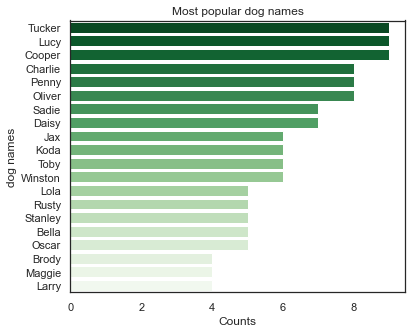

In [116]:
plt.figure(figsize=(6, 5))
x = df['names'].value_counts().head(20)
sns.barplot(x.values, x.index, palette='Greens_r').set(title='Most popular dog names', xlabel='Counts', ylabel='dog names')

The Tucker, Lucy and Cooper names are the most popular

 - What dog types are the most popular

In [117]:
df['types'].value_counts()

pupper           157
doggo             51
puppo             19
doggo,pupper       8
floofer            7
doggo,puppo        1
doggo,floofer      1
Name: types, dtype: int64

[Text(0.5, 1.0, 'Most popular dog types'),
 Text(0.5, 0, 'dog types'),
 Text(0, 0.5, 'value counts')]

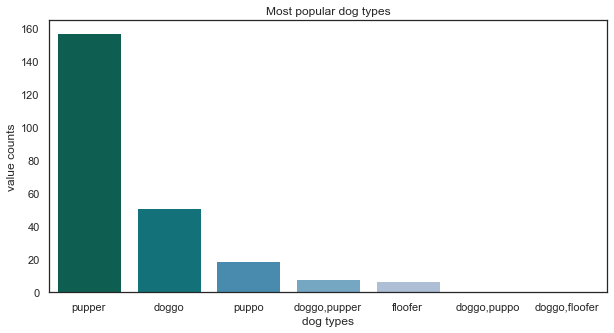

In [118]:
x = df['types'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x.index, x.values, palette='PuBuGn_r').set(title='Most popular dog types', xlabel='dog types', ylabel='value counts')

Pupper is the most popular dog type

 - Which dog has the highest confidence interval

In [119]:
df.groupby('types')['confidence'].sum()

types
doggo            25.937460
doggo,floofer     0.354733
doggo,pupper      6.523459
doggo,puppo       0.321676
floofer           4.264427
pupper           90.599764
puppo            12.254248
Name: confidence, dtype: float64

[Text(0.5, 1.0, 'Dog types with the highest confidence interval'),
 Text(0.5, 0, 'dog types'),
 Text(0, 0.5, 'confidence interval')]

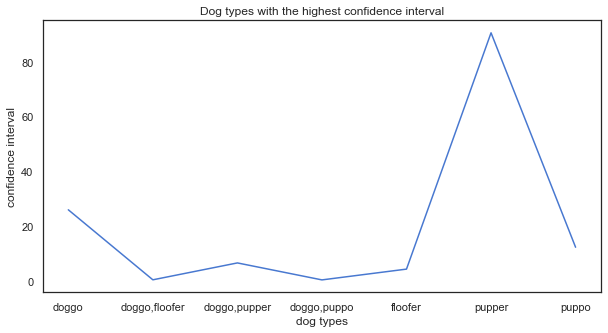

In [120]:
x = df.groupby('types')['confidence'].sum()
plt.figure(figsize=(10, 5))
sns.lineplot(x.index, x.values, ).set(title='Dog types with the highest confidence interval', xlabel='dog types', ylabel='confidence interval')

Pupper has the highest confidence interval

 - Most popular dog breeds

In [121]:
df['dog_breed'].value_counts().head(10)

golden_retriever      150
Labrador_retriever    102
Pembroke               92
Chihuahua              88
pug                    63
chow                   47
toy_poodle             47
Samoyed                40
Pomeranian             39
malamute               32
Name: dog_breed, dtype: int64

[Text(0.5, 1.0, 'Most popular dog breeds'),
 Text(0.5, 0, 'Number of breeds'),
 Text(0, 0.5, 'dog breed')]

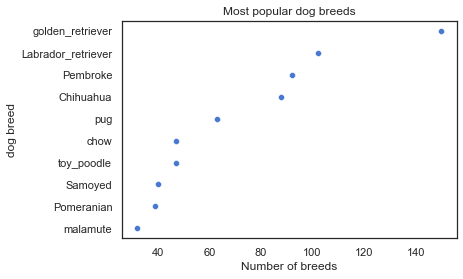

In [122]:
x = df['dog_breed'].value_counts().head(10)
sns.scatterplot(x.values, x.index).set(title='Most popular dog breeds', xlabel='Number of breeds', ylabel='dog breed')

`golden_retrievers` are the most popular dog breeds

 - Most rated dog breeds

In [123]:
df.groupby('dog_breed')['rating'].size().sort_values(ascending=False).head(20)

dog_breed
golden_retriever            150
Labrador_retriever          102
Pembroke                     92
Chihuahua                    88
pug                          63
toy_poodle                   47
chow                         47
Samoyed                      40
Pomeranian                   39
malamute                     32
cocker_spaniel               29
Chesapeake_Bay_retriever     28
miniature_pinscher           25
French_bulldog               23
German_shepherd              21
beagle                       20
Siberian_husky               20
Cardigan                     19
Maltese_dog                  19
Rottweiler                   19
Name: rating, dtype: int64

Text(0.5, 1.0, 'Most rated dog breeds')

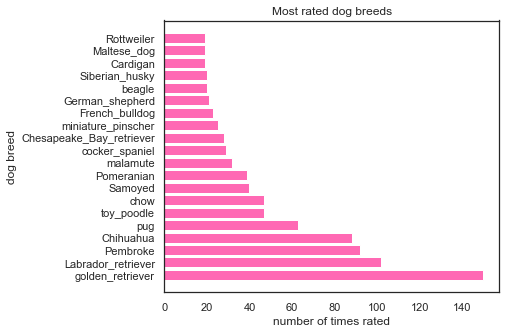

In [124]:
x = df.groupby('dog_breed')['rating'].size().sort_values(ascending=False).head(20)
plt.figure(figsize=(6, 5))
plt.barh(x.index, x.values, color='hotpink')
plt.xlabel('number of times rated')
plt.ylabel('dog breed')
plt.title('Most rated dog breeds')

Rottweilers are the dogs rated the most times

 - Mean retweet counts of dog types 

In [125]:
df.groupby('types')['retweet_count'].mean()

types
doggo             4958.843137
doggo,floofer     2750.000000
doggo,pupper      3559.375000
doggo,puppo      15684.000000
floofer           3906.285714
pupper            1639.165605
puppo             5577.842105
Name: retweet_count, dtype: float64

[Text(0.5, 1.0, 'Average retweet counts of dog types'),
 Text(0.5, 0, 'dog types'),
 Text(0, 0.5, 'Ave retweet count')]

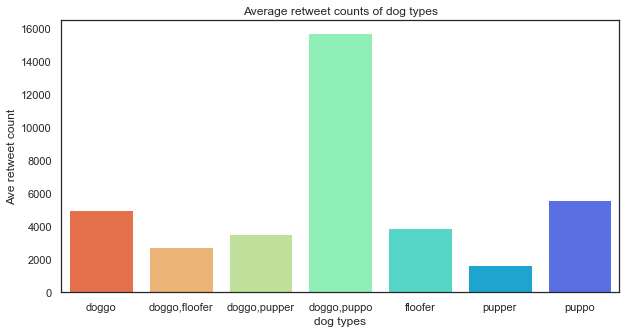

In [126]:
x = df.groupby('types')['retweet_count'].mean()
plt.figure(figsize=(10, 5))
sns.barplot(x.index, x.values, palette='rainbow_r').set(title='Average retweet counts of dog types', xlabel='dog types', ylabel='Ave retweet count')

`doggo,puppo` has the highest average retweet counts of any dog types

 - Mean retweet counts of dog breeds

In [127]:
df.groupby('dog_breed')['retweet_count'].mean().sort_values(ascending=False).head(20)

dog_breed
Bedlington_terrier         6562.333333
Afghan_hound               4697.333333
standard_poodle            4400.090909
English_springer           4318.100000
whippet                    4258.000000
Saluki                     4050.500000
flat-coated_retriever      3637.500000
Samoyed                    3527.250000
Bouvier_des_Flandres       3522.000000
Mexican_hairless           3355.571429
Tibetan_mastiff            3290.000000
Lakeland_terrier           3269.555556
black-and-tan_coonhound    3251.500000
Great_Pyrenees             3193.357143
cocker_spaniel             3170.344828
Leonberg                   3025.000000
Cardigan                   2971.000000
Labrador_retriever         2854.509804
golden_retriever           2805.900000
Irish_water_spaniel        2672.000000
Name: retweet_count, dtype: float64

[Text(0.5, 1.0, 'Average retweet counts of dog breeds'),
 Text(0, 0.5, 'dog breeds'),
 Text(0.5, 0, 'Ave retweet count')]

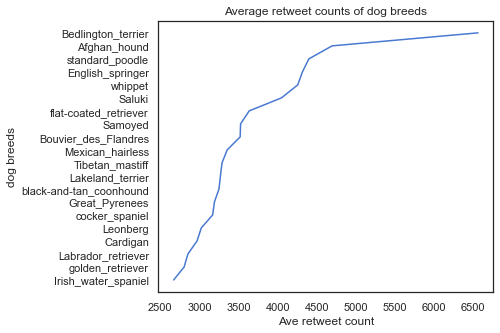

In [128]:
plt.figure(figsize=(6, 5))
x = df.groupby('dog_breed')['retweet_count'].mean().sort_values(ascending=False).head(20)
sns.lineplot(x.values, x.index, palette='rainbow_r').set(title='Average retweet counts of dog breeds', ylabel='dog breeds', xlabel='Ave retweet count')

Bedlington_terrier has the highest average retweet counts of any dog breeds

 - The average count of the most liked dog types

In [129]:
df.groupby('types')['favorite_count'].mean()

types
doggo            15697.882353
doggo,floofer    14378.000000
doggo,pupper     12285.875000
doggo,puppo      40337.000000
floofer          10933.714286
pupper            5354.012739
puppo            20398.263158
Name: favorite_count, dtype: float64

[Text(0.5, 1.0, 'Average counts of the most liked dog types'),
 Text(0.5, 0, 'dog types'),
 Text(0, 0.5, 'Ave count of likes')]

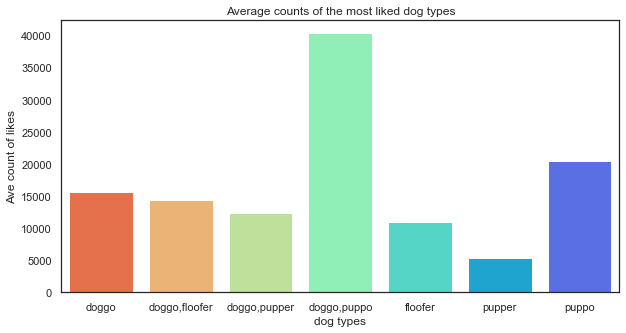

In [130]:
x = df.groupby('types')['favorite_count'].mean()
plt.figure(figsize=(10, 5))
sns.barplot(x.index, x.values, palette='rainbow_r').set(title='Average counts of the most liked dog types', xlabel='dog types', ylabel='Ave count of likes')

`doggo, puppo` are the dogs with the highest favorite counts of any dog types

 - The average count of the most liked dog breeds

In [131]:
df.groupby('dog_breed')['favorite_count'].mean().sort_values(ascending=False).head(20)

dog_breed
Bedlington_terrier         20995.666667
Saluki                     20216.500000
Bouvier_des_Flandres       14951.000000
Afghan_hound               14289.000000
black-and-tan_coonhound    14228.500000
flat-coated_retriever      14039.375000
whippet                    12720.900000
Leonberg                   12324.333333
English_springer           11820.700000
standard_poodle            11654.727273
French_bulldog             11473.826087
Irish_water_spaniel        11386.000000
Mexican_hairless           11275.714286
Samoyed                    10599.975000
Cardigan                   10438.736842
Lakeland_terrier           10341.277778
cocker_spaniel             10189.275862
Tibetan_mastiff            10016.500000
basset                     10004.562500
Weimaraner                  9988.500000
Name: favorite_count, dtype: float64

[Text(0.5, 1.0, 'Average counts of the most liked dog breeds'),
 Text(0, 0.5, 'dog breeds'),
 Text(0.5, 0, 'Ave count of likes')]

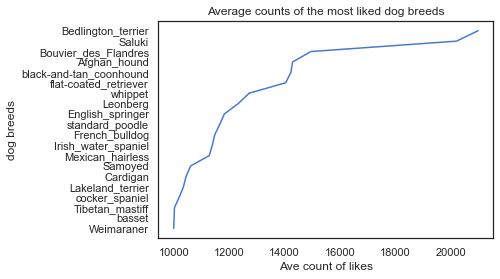

In [132]:
x = df.groupby('dog_breed')['favorite_count'].mean().sort_values(ascending=False).head(20)
sns.lineplot(x.values, x.index, palette='rainbow_r').set(title='Average counts of the most liked dog breeds', ylabel='dog breeds', xlabel='Ave count of likes')

Bedlington_terrier are the dogs with the highest favorite counts of any dog breeds

 - The most popular source of tweets

In [133]:
df.source.value_counts()

Twitter for iPhone    1584
Twitter Web Client      23
TweetDeck                8
Name: source, dtype: int64

[Text(0.5, 1.0, 'Sources of tweets'),
 Text(0.5, 0, 'Source'),
 Text(0, 0.5, 'Tweet count')]

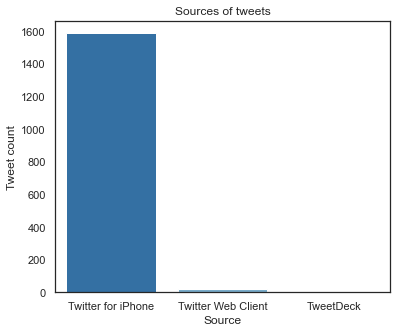

In [134]:
plt.figure(figsize=(6, 5))
x = df.source.value_counts()
sns.barplot(x.index, x.values, palette='Blues_r').set(title='Sources of tweets', xlabel='Source', ylabel='Tweet count')

Most tweets where from an iPhone

 - The highest average retweet counts by on dog names

In [135]:
df.groupby('names')['retweet_count'].mean().sort_values(ascending=False).head(20)

names
Stephan    50687.00
Duddles    36714.00
Aja        15516.00
Lilly      15158.00
Canela     14759.00
Darrel     14632.00
Kenneth    13661.00
Ken        13347.00
Rocco      10382.00
Barney     10202.00
Bo         10094.25
Butter      9492.00
Alfy        9414.00
Cupid       9177.00
Thor        9175.00
Lassie      9085.00
Klein       8658.00
Zoey        8594.00
Dewey       8494.00
Moreton     8441.00
Name: retweet_count, dtype: float64

[Text(0.5, 1.0, 'Highest average retweet_counts by dog names'),
 Text(0.5, 0, 'retweet counts'),
 Text(0, 0.5, 'names')]

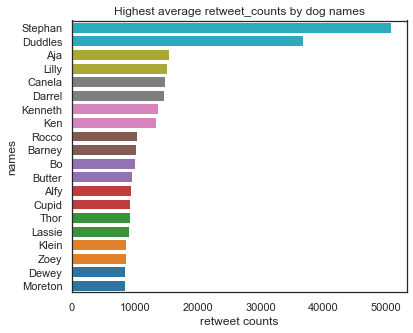

In [136]:
plt.figure(figsize=(6,5))
x = df.groupby('names')['retweet_count'].mean().sort_values(ascending=False).head(20)
sns.barplot(x.values, x.index, palette='tab10_r').set(title='Highest average retweet_counts by dog names', xlabel='retweet counts', ylabel='names')

Dogs named `Stephan` had the highest average retweet counts

 - Word Cloud of the tweets

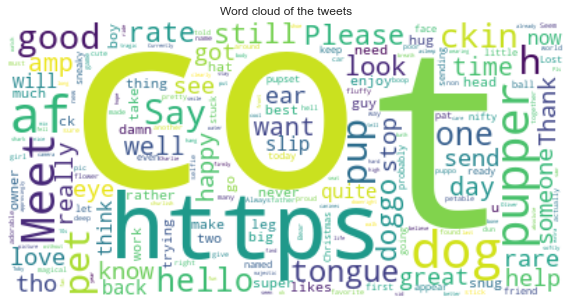

In [137]:
plt.figure(figsize=(10,10))
from wordcloud import WordCloud
text = " ".join(cat for cat in df.text)
wordcloud = WordCloud(collocations=False, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the tweets')
plt.show()

 - Word Cloud of dog breeds

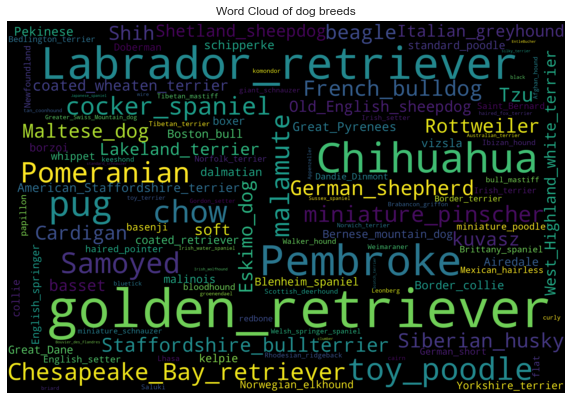

In [138]:
plt.figure(figsize=(10,10))
from wordcloud import WordCloud
text = " ".join(cat for cat in df.dog_breed)
wordcloud = WordCloud(collocations=False, background_color='black', width=3000, height=2000).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of dog breeds')
plt.show()